In [1]:
import numpy as np
import xarray as xr
import pickle
import pandas as pd
import time
import os

import datetime
from sys import getsizeof,path


import matplotlib.pyplot as plt
import matplotlib

import theano
import theano.tensor as tt
import pymc3 as pm
theano.config.optimizer="fast_run"

[[ 1  5  5]
 [ 4  3  2]
 [ 3  4  2]
 [ 2 -1  1]]
[]


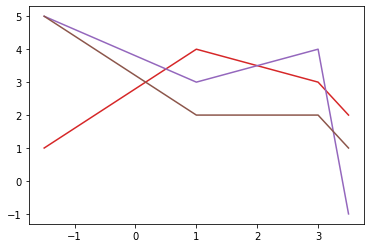

In [158]:
def CatmullRomSpline(cp,space,alpha=.5):
    # Centripetal at alpha = .5
    
    # t-space
    def tj(ti,p1,p2):
        d = p2-p1
        dd = tt.dot(d,d)
        return tt.pow(dd,alpha/1)+ti
    t0 = 0
    t1 = tj(t0,cp[0],cp[1])
    t2 = tj(t1,cp[1],cp[2])
    t3 = tj(t2,cp[2],cp[3])
    # map evaluation space
    space1 = (space-cp[1,0])/(cp[2,0]-cp[1,0])
    tspace = ( t1 + space1*(t2-t1) ).dimshuffle('x',0)
    
    # broadcast
    p = cp[:,1:].dimshuffle(0,1,'x')
    
    A1 = p[0] * (t1-tspace)/(t1-t0) + p[1] * (tspace-t0)/(t1-t0)
    A2 = p[1] * (t2-tspace)/(t2-t1) + p[2] * (tspace-t1)/(t2-t1)
    A3 = p[2] * (t3-tspace)/(t3-t2) + p[3] * (tspace-t2)/(t3-t2)
    B1 = (t2-tspace)/(t2-t0)*A1 + (tspace-t0)/(t2-t0)*A2
    B2 = (t3-tspace)/(t3-t1)*A2 + (tspace-t1)/(t3-t1)*A3
    C = (t2-tspace)/(t2-t1)*B1 + (tspace-t1)/(t2-t1)*B2
    return C

def SplineFromPositionsAndValues(control_values,control_points,space):
    # values and control_points have to have same 2nd dimension 
    # dimension of control_values = (4,n) for n control-points
    # dimension of control_poinst = 4 (positions)
    cp = tt.concatenate([tt.cast(control_points,"float32").dimshuffle(0,"x"),control_values],axis=1)
    return CatmullRomSpline(cp,space)
    
ct = np.array([-1.5,1,3,3.5],dtype="float32")
cp = np.array([[1,5,5],[4,3,2],[3,4,2],[2,-1,1]])
#cp = np.array([[-1,1],[1,4],[3,3],[4,3]])

ctt = tt.cast(ct,"float32")
cpt = tt.cast(cp,"float32")
#c = tt.concatenate([ct,cpt],axis=1)

#print(c.eval())

s = []#[1,1.1,1.2,1.5,1.8,1.9,2,2.5,2.7,3]
st = tt.cast(s,"float32")

#ccrs = CentripetalCatmullRomSpline(c,st).eval()
ccrs = SplineFrom(cp,ct,st).eval()

print(ccrs)

plt.plot(s,ccrs.transpose(1,0))
plt.plot(ct,cp)

In [184]:
# position of control points
ct = [-2,0,2,4,6,8,12,14]
cv = [1,2,3,6,6,7,3,1]

# evaluate at
et = np.array([0,.1,.2,.3,1.,2.2,6.1,6.8,7,9.1,9.2,9.3,10,11,11.9])

def SplitSpaceByControlPoints(control_points,evaluation_points):
    """
    """
    cp,ep = control_points,evaluation_points
    ir,cr = [],[]
    for start,end in zip(cp[1:-2],cp[2:-1]):
        idx = np.where((ep >= start )*(ep < end))
        ir.append(idx)
        cr.append( ep[ idx ] )
    return ir,cr
    
SplitSpaceByControlPoints(ct,et)



([(array([0, 1, 2, 3, 4]),),
  (array([5]),),
  (array([], dtype=int64),),
  (array([6, 7, 8]),),
  (array([ 9, 10, 11, 12, 13, 14]),)],
 [array([0. , 0.1, 0.2, 0.3, 1. ]),
  array([2.2]),
  array([], dtype=float64),
  array([6.1, 6.8, 7. ]),
  array([ 9.1,  9.2,  9.3, 10. , 11. , 11.9])])

In [2]:
def CentripetalCatmullRomChain(controlPoints,evaluateAt):
    """
        controlPoints (n,2) x,y coordinates of x-sorted controlPoints
    """
    pass

In [157]:

cpp = tt.cast([5,6,7,13],"float32")
space = np.linspace(6,7,32)

print(cpp.eval())
with pm.Model() as model:
    v = pm.Normal(name="vl_var",shape=(4,2))

    
    t = SplineFromPositionsAndValues(v,cpp,space)
    pm.Deterministic("sum",t)
    
    trace = pm.sample(init="advi+adapt_diag",return_inferencedata=True,tune=100,draws=100,cores=2,chains=2)

[ 5.  6.  7. 13.]


Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 3500
Interrupted at 3,499 [1%]: Average Loss = 0.28886
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [vl_var]


Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 6 seconds.


In [154]:
trace.posterior["sum"][0][0]

<xarray.DataArray 'sum' (sum_dim_0: 2, sum_dim_1: 32)>
array([[1.40771951, 1.39736876, 1.38404317, 1.3679172 , 1.34916529,
        1.32796192, 1.30448155, 1.27889862, 1.25138761, 1.22212297,
        1.19127916, 1.15903064, 1.12555187, 1.09101731, 1.05560142,
        1.01947866, 0.98282348, 0.94581035, 0.90861373, 0.87140808,
        0.83436785, 0.79766751, 0.76148152, 0.72598432, 0.6913504 ,
        0.65775419, 0.62537017, 0.5943728 , 0.56493652, 0.53723581,
        0.51144512, 0.48773891],
       [0.65310466, 0.67091437, 0.68785703, 0.70397091, 0.71929432,
        0.73386557, 0.74772294, 0.76090474, 0.77344927, 0.78539482,
        0.7967797 , 0.80764219, 0.81802061, 0.82795324, 0.83747839,
        0.84663436, 0.85545944, 0.86399193, 0.87227014, 0.88033235,
        0.88821687, 0.895962  , 0.90360604, 0.91118728, 0.91874402,
        0.92631456, 0.93393721, 0.94165025, 0.94949199, 0.95750072,
        0.96571475, 0.97417237]])
Coordinates:
    chain      int64 0
    draw       int64 0
  * sum_dim_0  (sum_dim_0) int64 0 1
  * sum_dim_1  (sum_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31